In [2]:
#Espacio de trabajo
import pandas as pd
import sys
import tqdm
#import lda2vec as l2v

import spacy
from spacy_spanish_lemmatizer import SpacyCustomLemmatizer

import numpy as np
from numpy.random import seed
from numpy.random import randint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator

import gensim
from gensim import corpora, similarities, models
from gensim.models.phrases import Phraser
#from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
from gensim.models import Phrases

import multiprocessing
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from IPython.display import display

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import wordcloud
from pprint import pprint
import re

import pyLDAvis
pyLDAvis.enable_notebook()

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings('ignore')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOSE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
path = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/OIM/Xenofobia_Mexico.xls'
df = pd.read_excel('Xenofobia_Mexico.xls')

print(df.shape)
df.head()

(5895, 37)


,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,Language,...,Twitter Screen Name,User Profile Url,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags
0,31-May-2021 11:58PM,NaN,https://twitter.com/servandomota/statuses/1399...,NaN,@ChivasFemenil Oigan y el pendejo que no narro...,Twitter,@servandomota,Mexico,NaN,Spanish / Castilian,...,пятнышко,https://twitter.com/servandomota,Solo tú puedes hacer mejor este mundo,146.0,417.0,"May 31, 2021",23:58:00,Nuevo León,Monterrey,NaN
1,31-May-2021 11:13PM,NaN,https://twitter.com/AdrianOchoa78/statuses/139...,NaN,@JeniGiornalista @FC_Cotz Es chapin?,Twitter,@adrianochoa78,Mexico,NaN,Spanish / Castilian,...,Ochoa. 🇲🇽,https://twitter.com/AdrianOchoa78,Me gusta el fútbol de Sudáfrica 🇿🇦. Doy voz a ...,1048.0,718.0,"May 31, 2021",23:13:00,Baja California,Tijuana,NaN
2,31-May-2021 08:59PM,NaN,https://twitter.com/_eliza1Capri_s/statuses/13...,NaN,@GuanacoRebane Jajajsjsjss 100% segura! 😉,Twitter,@_eliza1capri_s,Mexico,NaN,Spanish / Castilian,...,Elizabeth 🖤 Chivacapri🇲🇽 🐐,https://twitter.com/_eliza1Capri_s,"Mi eterno amor mi hijo, mi pasión mis amadas @...",16275.0,14043.0,"May 31, 2021",20:59:00,Colima,Colima,NaN
3,31-May-2021 08:58PM,NaN,https://twitter.com/Mximo35864565/statuses/139...,NaN,@catracho8a @gurudeportes30 Ez ke los del pria...,Twitter,@mximo35864565,Mexico,NaN,Spanish / Castilian,...,Máximo,https://twitter.com/Mximo35864565,Enemigo de todo lo que huela a 4t,214.0,216.0,"May 31, 2021",20:58:00,Mexico City,NaN,NaN
4,31-May-2021 08:53PM,NaN,http://twitter.com/Djba_98/statuses/1399544674...,NaN,RT @JorgeRdeportes: ORGULLO CATRACHO 🇭🇳 Por pr...,Twitter,@Djba_98,Mexico,NaN,Spanish / Castilian,...,DB🥦,http://www.twitter.com/Djba_98,Tengo a Román cómo ideología de vida. Pocas ve...,709.0,2382.0,"May 31, 2021",20:53:00,San Luis Potosí,La Boca,NaN


In [4]:
df = df.loc[df['Source']=='Twitter']

df = df.loc[~(df['Hit Sentence'].str.startswith('RT', na=False))]

df = df[['Date', 'Hit Sentence', 'Influencer', 'Sentiment', 'Key Phrases', 'Input Name', 'Keywords']]

print(df.shape)
df.head()

(2224, 7)


,Date,Hit Sentence,Influencer,Sentiment,Key Phrases,Input Name,Keywords
0,31-May-2021 11:58PM,@ChivasFemenil Oigan y el pendejo que no narro...,@servandomota,Positive,gol de tigres,Adhoc Search Export,guanacos
1,31-May-2021 11:13PM,@JeniGiornalista @FC_Cotz Es chapin?,@adrianochoa78,Neutral,NaN,Adhoc Search Export,chapin
2,31-May-2021 08:59PM,@GuanacoRebane Jajajsjsjss 100% segura! 😉,@_eliza1capri_s,Neutral,NaN,Adhoc Search Export,GuanacoRebane
3,31-May-2021 08:58PM,@catracho8a @gurudeportes30 Ez ke los del pria...,@mximo35864565,Neutral,lógica chaira,Adhoc Search Export,catracho8a
5,31-May-2021 08:34PM,@catracho8a @gurudeportes30 Rascale en sus pat...,@aleclerc1962,Negative,NaN,Adhoc Search Export,catracho8a


In [5]:
#Eliminamos los URL: Todo lo que empieza por  HTTP
df['Clean_Text']=df['Hit Sentence'].replace(r"http\S+", '', regex=True)
#Eliminamos todos los hashtags
df['Clean_Text']=df['Clean_Text'].replace('#\\w+', '', regex=True)
#Eliminamos los signos de puntuación repetidos dentro de los tweets
df['Clean_Text']=df['Clean_Text'].replace(r'([^0-9a-zA-Z])\1+', r'\1', regex=True)
#Eliminamos los signos de puntuación al inicio de un tweet
df['Clean_Text']=df['Clean_Text'].replace(r'^[^0-9a-zA-Z@#]+', '', regex=True)
#Eliminamos los dobles espacios
df['Clean_Text']=df['Clean_Text'].replace(r'()\1+', r'\1\1', regex=True)
#Eliminamos las letras repetivas dentro de las palabras
df['Clean_Text']=df['Clean_Text'].replace(r'(.)\1+', r'\1\1', regex=True)
# Quitar las comillas de los textos
df['Clean_Text']=df['Clean_Text'].replace('"', '', regex=True)
# Remover puntuaciones innecesarias
df['Clean_Text'] = df['Clean_Text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Remover mayúsculas de inicio de texto
df['Clean_Text'] = df['Clean_Text'].map(lambda x: x.lower())
# Quitamos las menciones a otros usuarios. (Hipotesis: El @ no impacta el sentimiento que puede tener el mensaje)
df['Clean_Text'] = df['Clean_Text'].map(lambda x: re.sub(r'@\S+\s', '', x))

df=df.reset_index(drop=True)
df=df.reset_index()
df = df.astype({"Clean_Text": str})
df.head(11)

,index,Date,Hit Sentence,Influencer,Sentiment,Key Phrases,Input Name,Keywords,Clean_Text
0,0,31-May-2021 11:58PM,@ChivasFemenil Oigan y el pendejo que no narro...,@servandomota,Positive,gol de tigres,Adhoc Search Export,guanacos,oigan y el pendejo que no narro el 2 gol de ti...
1,1,31-May-2021 11:13PM,@JeniGiornalista @FC_Cotz Es chapin?,@adrianochoa78,Neutral,NaN,Adhoc Search Export,chapin,es chapin
2,2,31-May-2021 08:59PM,@GuanacoRebane Jajajsjsjss 100% segura! 😉,@_eliza1capri_s,Neutral,NaN,Adhoc Search Export,GuanacoRebane,jajajsjsjss 100% segura 😉
3,3,31-May-2021 08:58PM,@catracho8a @gurudeportes30 Ez ke los del pria...,@mximo35864565,Neutral,lógica chaira,Adhoc Search Export,catracho8a,ez ke los del prian rovavan mázlógica chaira
4,4,31-May-2021 08:34PM,@catracho8a @gurudeportes30 Rascale en sus pat...,@aleclerc1962,Negative,NaN,Adhoc Search Export,catracho8a,rascale en sus patrimoniales a como hizo loret...
5,5,31-May-2021 08:31PM,Honduras se juega todo en la CONCACAF Nations ...,@ZonaDeportesMX4,Neutral,NaN,Adhoc Search Export,catracho,honduras se juega todo en la concacaf nations ...
6,6,31-May-2021 07:11PM,@tdtvhn @makawas Deberían de promoverlo más es...,@clozanof1968,Neutral,orgullo de catracho,Adhoc Search Export,catracho,deberían de promoverlo más es un orgullo de ca...
7,7,31-May-2021 06:19PM,QT @FenafuthOrg: Honduras viajó este lunes a D...,@e_deportivo,Negative,NaN,Adhoc Search Export,Catrachos,qt honduras viajó este lunes a denver para enf...
8,8,31-May-2021 06:08PM,@TerratsJordi @catracho8a @gurudeportes30 Yo p...,@ingfeliperiver1,Negative,efecto cangrejo uh,Adhoc Search Export,catracho8a,yo pienso q lo más sano si hay problemas con n...
9,9,31-May-2021 04:40PM,@catracho8a @gurudeportes30 Eres del club de l...,@terratsjordi,Positive,NaN,Adhoc Search Export,catracho8a,eres del club de la chairizaque viven en el pa...


In [6]:
# Le decimos a spaCy que vamos con toda
#spacy.prefer_gpu()
#spacy.require_gpu()

# Corremos los datos en el core de español
nlp = spacy.load("es_core_news_sm", exclude=["ner", "parser"])

lemmatizer_spa = SpacyCustomLemmatizer()

#Vemos cuales son los componentes del pipeline
print(nlp.pipe_names)

#Aplicamos el pipe a cada objeto de nuestra lista de tweets
print('---------SPACY-----------')
%time docs = list(nlp.pipe(df.Clean_Text.to_list()))

['tok2vec', 'morphologizer', 'attribute_ruler', 'lemmatizer']
---------SPACY-----------
Wall time: 3.23 s


In [7]:
print('---------TOKENIZATION-----------')
tokens=[]
for doc in docs:
    tokens.append([(token.text) for token in doc])

tokens=np.array(tokens)
tokens=pd.DataFrame(tokens).reset_index()
tokens.columns=['index', 'tokens']

tokens.head()
print('---------POS-----------')
pos=[]
for doc in docs:
    pos.append([(token.text, token.pos_) for token in doc])

pos=np.array(pos)
pos=pd.DataFrame(pos).reset_index()
pos.columns=['index', 'pos']
df=pd.merge(df, tokens, how='inner', on='index')
df=pd.merge(df, pos, how='inner', on='index')
print('---------STOPWORDS-----------')
spanish_stopwords=stopwords.words('spanish')
spanish_stopwords.extend(['ser', 'haber'])
spanish_stopwords.remove('no')
spanish_stopwords.remove('ni')
# ,'venezolano', 'venezolanos', 'venezolana', 'venezolanas', 'veneco', 'veneca', 'venecos', 'venecas'
%time df['words']=df['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() and token.lower() not in spanish_stopwords and len(token)>1])

#N-GRAMS
tokens = df['words'].tolist()
bigram_model = gensim.models.phrases.Phrases(tokens, min_count=5, threshold=20)
trigram_model = gensim.models.phrases.Phrases(bigram_model[tokens], min_count=2, threshold=20)
tokens = list(trigram_model[bigram_model[tokens]])
print('---------N-GRAMS-----------')
print(trigram_model[bigram_model[tokens[0]]])

print('---------LEMMATIZER-----------')
lemma=[]
for doc in docs:
    lemma.append([(token.lemma_) for token in doc])
data_lemmatized = lemma
lemma=np.array(lemma)
lemma=pd.DataFrame(lemma).reset_index()
lemma.columns=['index', 'lemmatized']

print('---------Datos lemmatized-----------')
print(lemma[:1])

#MERGE LISTS INTO DF
df=pd.merge(df, lemma, how='inner', on='index')
df=df.drop(['index'], axis=1)

print('---------STOPWORDS-----------')
%time df['lem_words']=df['lemmatized'].map(lambda tokens: [token.lower() for token in tokens if token.lower() not in spanish_stopwords and len(token)>1])

print('--------BASE-FINAL--------')
df.head(11)

---------TOKENIZATION-----------
---------POS-----------
---------STOPWORDS-----------
Wall time: 109 ms
---------N-GRAMS-----------
['oigan', 'pendejo', 'no', 'narro', 'gol', 'tigres', 'guanacos', 'mariachi']
---------LEMMATIZER-----------
---------Datos lemmatized-----------
   index                                         lemmatized
0      0  [oigar, y, el, pendejo, que, no, narrar, el, 2...
---------STOPWORDS-----------
Wall time: 127 ms
--------BASE-FINAL--------


,Date,Hit Sentence,Influencer,Sentiment,Key Phrases,Input Name,Keywords,Clean_Text,tokens,pos,words,lemmatized,lem_words
0,31-May-2021 11:58PM,@ChivasFemenil Oigan y el pendejo que no narro...,@servandomota,Positive,gol de tigres,Adhoc Search Export,guanacos,oigan y el pendejo que no narro el 2 gol de ti...,"[oigan, y, el, pendejo, que, no, narro, el, 2,...","[(oigan, VERB), (y, CCONJ), (el, DET), (pendej...","[oigan, pendejo, no, narro, gol, tigres, guana...","[oigar, y, el, pendejo, que, no, narrar, el, 2...","[oigar, pendejo, no, narrar, gol, tigre, guana..."
1,31-May-2021 11:13PM,@JeniGiornalista @FC_Cotz Es chapin?,@adrianochoa78,Neutral,NaN,Adhoc Search Export,chapin,es chapin,"[es, chapin]","[(es, AUX), (chapin, NOUN)]",[chapin],"[ser, chapin]",[chapin]
2,31-May-2021 08:59PM,@GuanacoRebane Jajajsjsjss 100% segura! 😉,@_eliza1capri_s,Neutral,NaN,Adhoc Search Export,GuanacoRebane,jajajsjsjss 100% segura 😉,"[jajajsjsjss, 100%, segura, 😉]","[(jajajsjsjss, ADJ), (100%, SYM), (segura, ADJ...","[jajajsjsjss, segura]","[jajajsjsjss, 100%, seguro, 😉]","[jajajsjsjss, 100%, seguro]"
3,31-May-2021 08:58PM,@catracho8a @gurudeportes30 Ez ke los del pria...,@mximo35864565,Neutral,lógica chaira,Adhoc Search Export,catracho8a,ez ke los del prian rovavan mázlógica chaira,"[ez, ke, los, del, prian, rovavan, mázlógica, ...","[(ez, VERB), (ke, PRON), (los, DET), (del, ADP...","[ez, ke, prian, rovavan, mázlógica, chaira]","[ez, ke, el, del, prian, rovair, mázlógico, ch...","[ez, ke, prian, rovair, mázlógico, chairo]"
4,31-May-2021 08:34PM,@catracho8a @gurudeportes30 Rascale en sus pat...,@aleclerc1962,Negative,NaN,Adhoc Search Export,catracho8a,rascale en sus patrimoniales a como hizo loret...,"[rascale, en, sus, patrimoniales, a, como, hiz...","[(rascale, VERB), (en, ADP), (sus, DET), (patr...","[rascale, patrimoniales, hizo, loret, si, algú...","[rascalir, en, su, patrimonial, a, como, hacer...","[rascalir, patrimonial, hacer, loret, si, tene..."
5,31-May-2021 08:31PM,Honduras se juega todo en la CONCACAF Nations ...,@ZonaDeportesMX4,Neutral,NaN,Adhoc Search Export,catracho,honduras se juega todo en la concacaf nations ...,"[honduras, se, juega, todo, en, la, concacaf, ...","[(honduras, NOUN), (se, PRON), (juega, VERB), ...","[honduras, juega, concacaf, nations, league, h...","[hondura, él, jugar, todo, en, el, concacaf, n...","[hondura, jugar, concacaf, nations, leagar, ha..."
6,31-May-2021 07:11PM,@tdtvhn @makawas Deberían de promoverlo más es...,@clozanof1968,Neutral,orgullo de catracho,Adhoc Search Export,catracho,deberían de promoverlo más es un orgullo de ca...,"[deberían, de, promoverlo, más, es, un, orgull...","[(deberían, AUX), (de, ADP), (promoverlo, VERB...","[deberían, promoverlo, orgullo, catracho]","[deber, de, promover él, más, ser, uno, orgull...","[deber, promover él, orgullo, catracho]"
7,31-May-2021 06:19PM,QT @FenafuthOrg: Honduras viajó este lunes a D...,@e_deportivo,Negative,NaN,Adhoc Search Export,Catrachos,qt honduras viajó este lunes a denver para enf...,"[qt, honduras, viajó, este, lunes, a, denver, ...","[(qt, SCONJ), (honduras, NOUN), (viajó, VERB),...","[qt, honduras, viajó, lunes, denver, enfrentar...","[qt, hondura, viajar, este, lunes, a, denver, ...","[qt, hondura, viajar, lunes, denver, enfrentar..."
8,31-May-2021 06:08PM,@TerratsJordi @catracho8a @gurudeportes30 Yo p...,@ingfeliperiver1,Negative,efecto cangrejo uh,Adhoc Search Export,catracho8a,yo pienso q lo más sano si hay problemas con n...,"[yo, pienso, q, lo, más, sano, si, hay, proble...","[(yo, PRON), (pienso, VERB), (q, SCONJ), (lo, ...","[pienso, sano, si, problemas, sociedad, mexica...","[yo, pensar, q, él, más, sano, si, haber, prob...","[pensar, sano, si, problema, sociedad, mexican..."
9,31-May-2021 04:40PM,@catracho8a @gurudeportes30 Eres del club de l...,@terratsjordi,Positive,NaN,Adhoc Search Export,catracho8a,eres del club de la chairizaque viven en el pa...,"[eres, del, club, de, la, chairizaque, viven, ...","[(eres, AUX), (del, ADP), (cl

# W2V

In [8]:
docs = list(df['lem_words'])

phrases = Phrases(docs, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
frases = bigram[docs]

frases[0]

['oigar', 'pendejo', 'no', 'narrar', 'gol', 'tigre', 'guanaco', 'mariachi']

In [9]:
w2v_model = Word2Vec(min_count=3, window=4, sample=1e-5, alpha=0.03, 
                     min_alpha=0.0007, negative=20, 
                     workers=multiprocessing.cpu_count()-1)


w2v_model.build_vocab(frases, progress_per=50000)

In [10]:
w2v_model.train(frases, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

w2v_model.init_sims(replace=True)

word_vectors = w2v_model.wv

w2v_model.save("word2vec.model")

In [17]:
print(word_vectors)

In [25]:
X = w2v_model.wv.vectors
df2 = pd.DataFrame(X)
df2.shape
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.137533,0.134151,0.007967,0.015118,0.001336,-0.096468,0.042138,0.255946,-0.030541,-0.063639,...,-0.045897,0.017936,0.005593,-0.053650,0.239489,0.202196,0.117144,-0.155802,0.076244,0.030122
1,-0.140333,0.135208,0.008541,0.015113,0.005260,-0.096967,0.041086,0.256161,-0.030473,-0.064524,...,-0.045659,0.017512,0.005457,-0.056080,0.236832,0.202552,0.120489,-0.155486,0.073705,0.029975
2,-0.137431,0.134995,0.004772,0.012857,0.005315,-0.093114,0.040076,0.254924,-0.031980,-0.061221,...,-0.047035,0.019566,0.007389,-0.054556,0.239998,0.203118,0.120589,-0.154239,0.078315,0.026812
3,-0.140208,0.137382,0.006877,0.013020,0.004727,-0.096437,0.041889,0.256288,-0.028294,-0.065191,...,-0.047856,0.017971,0.004852,-0.054769,0.240714,0.201745,0.121328,-0.156636,0.075585,0.026885
4,-0.140279,0.135005,0.004523,0.012688,0.004506,-0.093300,0.041270,0.255616,-0.031076,-0.060606,...,-0.044539,0.016525,0.006296,-0.054956,0.239432,0.199247,0.121748,-0.153496,0.076802,0.029857


In [26]:
#Computing the correlation matrix
X_corr=df2.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

#Projecting it onto new dimesion with 2 axis
neww_X=np.dot(X,new_vectors)

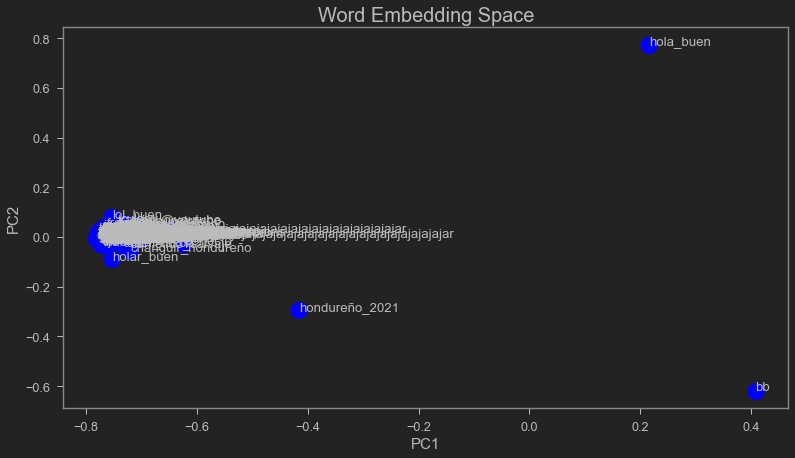

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.scatter(neww_X[:,0],neww_X[:,1],linewidths=10,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=list(w2v_model.wv.index_to_key)
for i, word in enumerate(vocab):
    plt.annotate(word,xy=(neww_X[i,0],neww_X[i,1]))

In [50]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['pendejo', 'hondureño', 'catracho', 'puta', 'salvadoreño', 'guatemalteco', 'gringo']}
similar_words

{'pendejo': ['tener', 'gol', 'chapin', 'qt', 'pais_hondura'],
 'hondureño': ['qt', 'no', 'catracho', 'tener', 'cdg_alíar'],
 'catracho': ['no', 'qt', 'qt_rt', 'much_evidence', 'transmitir_aire\\n\\nla'],
 'puta': ['pasar', 'guanaco', 'empezar_negar', 'fútbol_varonil', 'diez'],
 'salvadoreño': ['fútbol',
  'organización_autogestión',
  'persona',
  'tener',
  'jugar'],
 'guatemalteco': ['no', 'qt', 'cdg_alíar', 'much_evidence', 'tener'],
 'gringo': ['qt',
  'gente',
  'deportado_carecer',
  'transmitir_aire\\n\\nla',
  'for']}

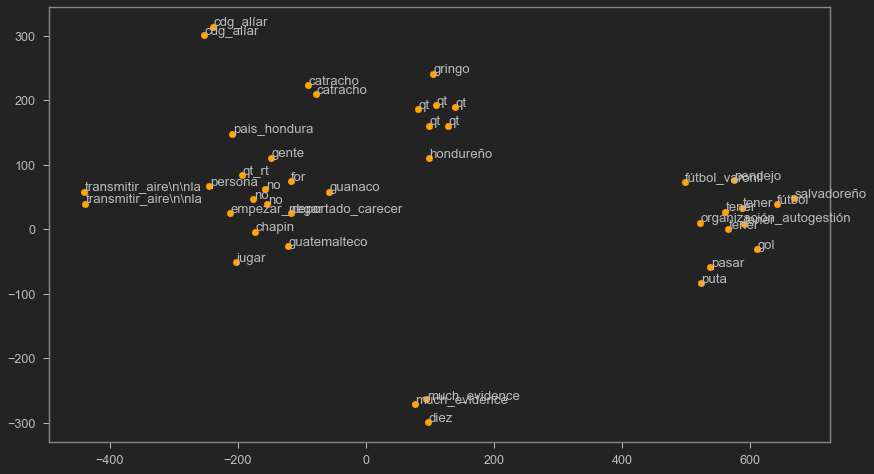

In [51]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# Clustering (KMeans)

In [60]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [61]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('hola_buen', 0.685844361782074),
 ('bb', 0.6858443021774292),
 ('perfecto', 0.23885175585746765),
 ('pinch_catracho', 0.2385958433151245),
 ('costa_rico', 0.21429671347141266),
 ('changuir_hondureño', 0.2097950279712677),
 ('farsante', 0.20915867388248444),
 ('crack', 0.20871056616306305),
 ('eh', 0.20618142187595367),
 ('baquedano', 0.20570369064807892)]

In [62]:
positive_cluster_index = 1
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

In [63]:
w_vec = pd.DataFrame(word_vectors.index_to_key)
w_vec.columns = ['words']
w_vec['vectors'] = w_vec.words.apply(lambda x: word_vectors[f'{x}'])
w_vec['cluster'] = w_vec.vectors.apply(lambda x: model.predict([np.array(x)]))
w_vec.cluster = w_vec.cluster.apply(lambda x: x[0])

In [64]:
w_vec['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in w_vec.cluster]
w_vec['closeness_score'] = w_vec.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
w_vec['sentiment_coeff'] = w_vec.closeness_score * w_vec.cluster_value

In [65]:
w_vec.head(10)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,no,"[-0.13753271, 0.13415137, 0.007967425, 0.01511...",0,-1,86.190237,-86.190237
1,catracho,"[-0.14033267, 0.13520831, 0.008541155, 0.01511...",0,-1,60.047467,-60.047467
2,qt,"[-0.13743085, 0.1349945, 0.00477234, 0.0128571...",0,-1,65.382078,-65.382078
3,qt_rt,"[-0.140208, 0.13738173, 0.00687668, 0.01302030...",0,-1,56.232145,-56.232145
4,si,"[-0.14027931, 0.13500477, 0.0045233998, 0.0126...",0,-1,50.375389,-50.375389
5,guanaco,"[-0.14026153, 0.1346761, 0.006499295, 0.009871...",0,-1,42.741999,-42.741999
6,tener,"[-0.13529171, 0.13313265, 0.0063436204, 0.0136...",0,-1,57.612088,-57.612088
7,chapin,"[-0.13493447, 0.13343914, 0.010533319, 0.01660...",0,-1,46.391552,-46.391552
8,ir,"[-0.14075217, 0.13770454, 0.008326602, 0.01696...",0,-1,43.779139,-43.779139
9,hacer,"[-0.13954565, 0.13222665, 0.004347174, 0.01626...",0,-1,51.327954,-51.327954


In [66]:
sentiment_dict = dict(zip(w_vec.words.values, w_vec.sentiment_coeff.values))

In [67]:
df['lem_text'] = df['lem_words'].apply(lambda x: ' '.join(bigram[x]))

predict = df[['lem_text', 'Sentiment']]

predict.head()

,lem_text,Sentiment
0,oigar pendejo no narrar gol tigre guanaco mari...,Positive
1,chapin,Neutral
2,jajajsjsjss 100% seguro,Neutral
3,ez ke prian rovair mázlógico chairo,Neutral
4,rascalir patrimonial hacer loret si tener algu...,Negative


# TFIDF 

In [68]:
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(predict.lem_text)
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(predict.lem_text)

In [69]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    inspired  by function from this wonderful article: 
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.lem_text.split()))

In [70]:
%%time
replaced_tfidf_scores = predict.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)

Wall time: 416 ms


In [71]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [72]:
replaced_closeness_scores = predict.lem_text.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [73]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, predict.lem_text, predict.Sentiment]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'Mensaje', 'Sentimet']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')

replacement_df

,sentiment_coeff,tfidf_scores,Mensaje,Sentimet,sentiment_rate,prediction
0,"[0, -20.254354634134383, -86.19023662489789, 0...","[7.608899905932231, 6.068454864985082, 2.56978...",oigar pendejo no narrar gol tigre guanaco mari...,Positive,-830.039148,0
1,[-46.39155202314176],[3.638607992380109],chapin,Neutral,-168.800672,0
2,"[0, -12.669587347174648, -13.762677305383587]","[8.014365014040395, 6.761602045545027, 6.40492...",jajajsjsjss 100% seguro,Neutral,-173.815653,0
3,"[0, -9.509561750258824, -9.939198785533643, 0,...","[8.014365014040395, 7.32121783348045, 7.321217...",ez ke prian rovair mázlógico chairo,Neutral,-269.291312,0
4,"[0, 0, -51.32795357344861, 0, -50.375388728987...","[8.014365014040395, 8.014365014040395, 11.3191...",rascalir patrimonial hacer loret si tener algu...,Negative,-3474.142825,0
...,...,...,...,...,...,...
2219,"[-30.51053205602742, -14.415371048466103]","[4.946312078906779, 6.6280706529205045]",seguir bro,Positive,-246.460711,0
2220,"[-13.93848930470826, -15.365347772024126, -17....","[6.915752725372285, 6.915752725372285, 6.91575...",top fan increíble via ver,Neutral,-491.476999,0
2221,"[-43.77913908952308, -35.55631517716625, -42.7...","[3.8399777441447585, 4.300792947336087, 3.4293...",ir poder guanaco,Neutral,-467.610575,0
2222,[-31.181228471015263],[5.711779921046349],favor,Positive,-178.100315,0


# LDA

In [24]:
data_lemmatized=list(df['lem_words'])
dictionary = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
dictionary.save('tweets_x.dict');
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('tweets_x.mm', corpus)
corpora.SvmLightCorpus.serialize('tweets_x.svmlight', corpus)
corpora.BleiCorpus.serialize('tweets_x.lda-c', corpus)
corpora.LowCorpus.serialize('tweets_x.low', corpus)
print('--------CORPUS----------')
print(corpus[:1])
##Then the dictionary and corpus can be used to train using LDA
np.random.seed(123456)
mm = corpora.MmCorpus('tweets_x.mm')
num_topics=10
%time lda = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=num_topics, update_every=0, passes=10, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary.keys()))

--------CORPUS----------
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]
CPU times: user 2.88 s, sys: 8.52 ms, total: 2.89 s
Wall time: 2.89 s


In [25]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('gol', 1),
  ('guanaco', 1),
  ('mariachi', 1),
  ('narrar', 1),
  ('no', 1),
  ('oigar', 1),
  ('pendejo', 1),
  ('tigre', 1)]]

In [26]:
pprint(lda.print_topics())
doc_lda = lda[corpus]

[(0,
  '0.028*"catracho" + 0.016*"qt" + 0.013*"hondura" + 0.013*"no" + '
  '0.012*"hondureño" + 0.012*"méxico" + 0.011*"si" + 0.007*"grande" + '
  '0.007*"rt" + 0.007*"detenido"'),
 (1,
  '0.028*"unido" + 0.024*"no" + 0.020*"hondura" + 0.019*"qt" + '
  '0.019*"catracho" + 0.016*"juego" + 0.015*"olímpico" + 0.013*"2020" + '
  '0.012*"quedar" + 0.012*"tokio"'),
 (2,
  '0.044*"catracho" + 0.021*"qt" + 0.020*"hondura" + 0.015*"pedir" + '
  '0.012*"ir" + 0.010*"no" + 0.010*"lago" + 0.010*"gool" + 0.010*"gol" + '
  '0.010*"tocar"'),
 (3,
  '0.020*"no" + 0.019*"qt" + 0.014*"tener" + 0.013*"migrante" + '
  '0.013*"catracho" + 0.009*"rt" + 0.008*"dar" + 0.008*"hacer" + '
  '0.006*"guanaco" + 0.006*"decir"'),
 (4,
  '0.026*"catracho" + 0.023*"poder" + 0.017*"chapin" + 0.016*"no" + '
  '0.015*"madre" + 0.014*"hacer" + 0.011*"guanaco" + 0.010*"ir" + '
  '0.010*"ninguno" + 0.010*"si"'),
 (5,
  '0.026*"qt" + 0.018*"guanaco" + 0.015*"migrante" + 0.014*"no" + 0.013*"rt" + '
  '0.012*"vacunación" + 0.0

In [28]:
vis = pyLDAvis.gensim_models.prepare(topic_model=lda, corpus=corpus, dictionary=dictionary)
pyLDAvis.display(vis, template_type='notebook')

In [ ]:
pyLDAvis.save_html(vis, 'ldax.html')

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.515181059777015

Coherence Score:  0.41335476343559774


In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=num_topics, update_every=0, passes=10, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary.keys()))
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [31]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=mm, texts=data_lemmatized, start=4, limit=20, step=2)

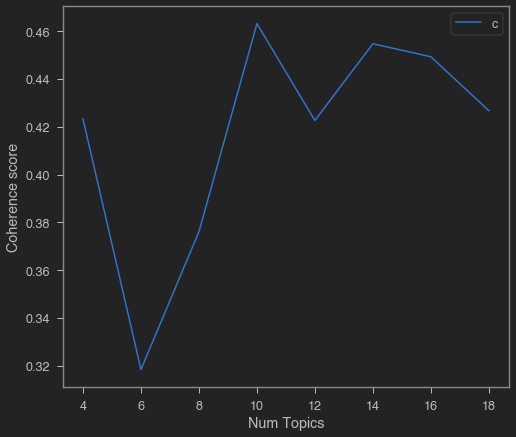

In [32]:
# Show graph
limit=20; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 2))

Num Topics = 4  has Coherence Value of 0.42
Num Topics = 6  has Coherence Value of 0.32
Num Topics = 8  has Coherence Value of 0.38
Num Topics = 10  has Coherence Value of 0.46
Num Topics = 12  has Coherence Value of 0.42
Num Topics = 14  has Coherence Value of 0.45
Num Topics = 16  has Coherence Value of 0.45
Num Topics = 18  has Coherence Value of 0.43


In [34]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.034*"catracho" + 0.021*"hondura" + 0.018*"olímpico" + 0.017*"juego" + '
  '0.014*"guanaco" + 0.014*"unido" + 0.013*"primero" + 0.012*"no" + '
  '0.010*"tokio" + 0.009*"gol"'),
 (1,
  '0.047*"no" + 0.021*"catracho" + 0.019*"qt" + 0.012*"hondureño" + '
  '0.011*"hacer" + 0.009*"chapin" + 0.008*"rt" + 0.007*"equipo" + 0.007*"si" + '
  '0.006*"tener"'),
 (2,
  '0.034*"qt" + 0.023*"guanaco" + 0.023*"rt" + 0.015*"catracho" + '
  '0.008*"justicia" + 0.007*"migrante" + 0.007*"no" + 0.007*"si" + '
  '0.006*"saber" + 0.006*"primero"'),
 (3,
  '0.023*"chapin" + 0.022*"no" + 0.018*"chapín" + 0.013*"catracho" + '
  '0.012*"amigo" + 0.012*"qt" + 0.009*"hacer" + 0.007*"saber" + '
  '0.007*"hondureño" + 0.007*"ir"'),
 (4,
  '0.022*"catracho" + 0.020*"no" + 0.014*"hondureño" + 0.013*"qt" + '
  '0.013*"méxico" + 0.012*"deportar" + 0.010*"tener" + 0.009*"poder" + '
  '0.009*"guatemala" + 0.008*"guanaco"'),
 (5,
  '0.028*"poder" + 0.027*"chapin" + 0.026*"no" + 0.025*"madre" + 0.017*"si" + '
  '0

In [35]:
visx = pyLDAvis.gensim_models.prepare(topic_model=optimal_model, corpus=corpus, dictionary=dictionary, mds='mmds')
pyLDAvis.display(visx)

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 4
max_topics = 20
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close() 

 12%|█▏        | 67/540 [10:05<1:12:57,  9.25s/it]

In [ ]:
tabla_tunning = pd.read_csv('lda_tuning_results.csv')
tabla_tunning

In [ ]:
tabla_tunning = tabla_tunning.sort_values(by = 'Coherence')
tabla_tunning

In [ ]:
corpus = corpora.MmCorpus('tweets_x.mm')
#dictionary = corpora.Dictionary('tweets_x.dict')
# EL mejor modelo

lda_final_model = gensim.models.LdaMulticore(corpus=mm,
                                             id2word=dictionary,
                                             num_topics=14,
                                             random_state=100,
                                             chunksize=100,
                                             passes=10,
                                             alpha=0.31,
                                             eta=0.61)

[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

pprint(lda_final_model.print_topics())
doc_lda = lda_final_model[corpus]

vis = pyLDAvis.gensim_models.prepare(topic_model=lda_final_model, corpus=corpus, dictionary=dictionary)
pyLDAvis.display(vis)